In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import gzip

# .gz확장자의 MNIST data파일에서 numpy 형태로 변환

## (참고하는 함수입니다. 알아야 할 필요 없음)

참고: https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python

In [3]:
def get_images(is_train=True):
    image_size=28
    if is_train:
        f = gzip.open('data/MNIST/raw/train-images-idx3-ubyte.gz','r')
        num_images = 60000
        f.read(16)
        buf = f.read(image_size * image_size * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, image_size, image_size, 1)
    else:
        f = gzip.open('data/MNIST/raw/t10k-images-idx3-ubyte.gz','r')
        num_images = 10000
        f.read(16)
        buf = f.read(image_size * image_size * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, image_size, image_size, 1)
    return data

In [4]:
def get_labels(is_train=True):
    if is_train:
        with gzip.open('data/MNIST/raw/train-labels-idx1-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of labels
            label_count = int.from_bytes(f.read(4), 'big')
            # rest is the label data, each label is stored as unsigned byte
            # label values are 0 to 9
            label_data = f.read()
            labels = np.frombuffer(label_data, dtype=np.uint8)
    else:
        with gzip.open('data/MNIST/raw/t10k-labels-idx1-ubyte.gz', 'r') as f:
            # first 4 bytes is a magic number
            magic_number = int.from_bytes(f.read(4), 'big')
            # second 4 bytes is the number of labels
            label_count = int.from_bytes(f.read(4), 'big')
            # rest is the label data, each label is stored as unsigned byte
            # label values are 0 to 9
            label_data = f.read()
            labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels



In [5]:
trn_x = get_images(True)
trn_y = get_labels(True)
tst_x = get_images(False)
tst_y = get_labels(False)

# Make Custom Dataset
<span style = 'font-size:1.2em;line-height:1.5em'>Pytorch에서 제공하는 torch.utils.data.Dataset을 활용하면 직접 custom dataset을 만들수 있습니다.</span>

```python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        # 데이터의 전처리를 해주는 부분
        pass
    
    def __len__(self):
        # 데이터셋의 길이. 즉, 총 샘플 갯수를 적어주는 부분
        pass
    
    def __getitem__(self, idx):
        # 데이터 셋에서 특정 1개의 샘플을 가져오는 함수
```

<span style = 'font-size:1.2em;line-height:1.5em'>위에서 만든 numpy형태의 MNIST데이터로 만들어보죠</span>

In [6]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, is_train=True, transform=None):
        self.images = get_images(is_train)
        self.labels = get_labels(is_train)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

<span style = 'font-size:1.2em;line-height:1.5em'>이렇게 하면 정상적으로 데이터가 추출이 됩니다</span>

In [7]:
my_data = MyDataset(is_train=True)

In [8]:
my_data.images.shape

(60000, 28, 28, 1)

In [9]:
image, label = my_data[0]

In [10]:
my_loader = DataLoader(my_data, batch_size=9)

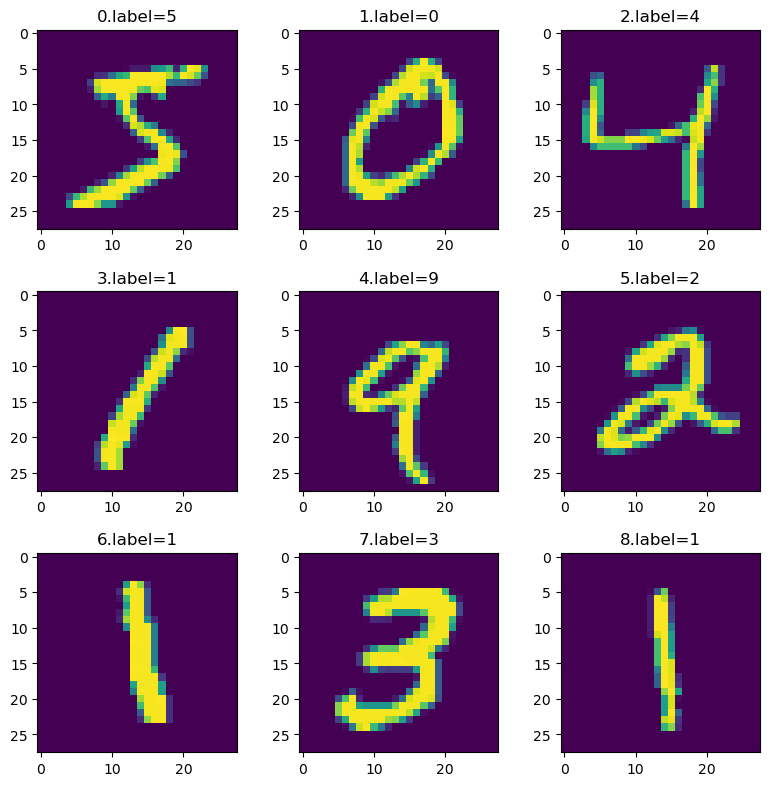

In [11]:
for x_batch, y_batch in my_loader:
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
    plt.tight_layout()
    for i in range(len(y_batch)):
        row_num = int(i/3)
        col_num = i%3
        ax[row_num, col_num].imshow(x_batch[i])
        ax[row_num, col_num].set_title(f'{i}.label={y_batch[i]}')
    break

# 음, 일단 좋습니다. Custom Dataset을 만들수 있는건 알겠어요

## 근데 이걸 왜 사용할까요?

<span style = 'font-size:1.2em;line-height:1.5em'>여러분이 사용할 데이터는 지금까지 사용한 MNIST 데이터처럼 묶음으로 되어 있지 않고, 개별 이미지 파일로 되어 있을겁니다.</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>예시) file1.jpg, file2.jpg,... 요런식으로요.</span>

<span style = 'font-size:1.2em;line-height:1.5em'>이런 데이터들을 batch단위로 모델에 입력할 때 유용합니다.</span>


## 예를 한번 들어볼까요?

### 예시를 만들기 위해 MNIST데이터중 50개 정도의 데이터를 png파일로 저장하겠습니다.

In [12]:
savedir = 'data/MNIST_sample'
if not os.path.exists(savedir):
    os.makedirs(savedir)

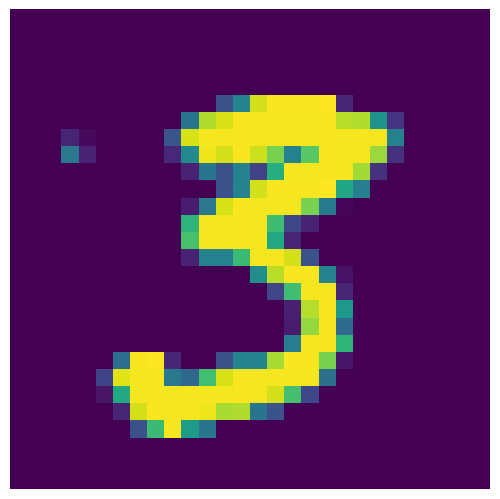

In [13]:
for i in range(50):
    fnum = str(i).zfill(2)
    fpath = os.path.join(savedir, f'file{fnum}_label_{trn_y[i]}.png')
    plt.axis('off')
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
    # plt.subplots_adjust(left = 0, bottom = 0, right = 0, top = 0, hspace = 0, wspace = 0)
    fig = plt.imshow(trn_x[i])
    plt.savefig(fpath, format='png')
    

### 이제 Custom Dataset을 만들어보겠습니다.

#### 먼저 image file path list를 생성합니다

In [16]:
from PIL import Image

In [17]:
fpath_list = sorted([os.path.join(savedir, x) for x in os.listdir(savedir)])

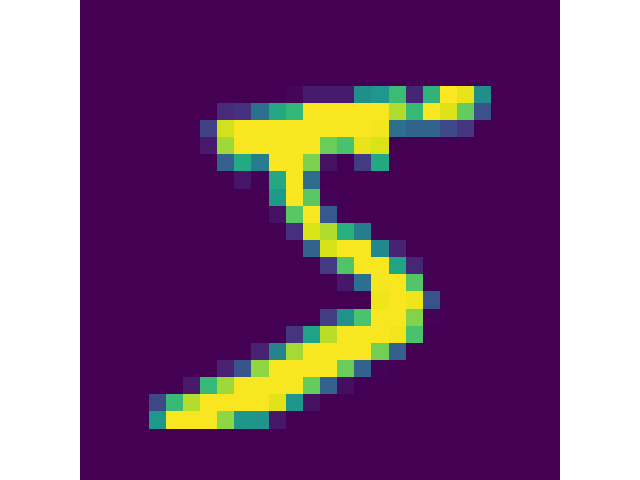

In [18]:
Image.open(fpath_list[0])

In [19]:
fpath_list[0]

'data/MNIST_sample/file00_label_5.png'

In [20]:
class MyDataset2(Dataset):
    def __init__(self, transform = None):
        self.file_list = fpath_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file = self.file_list[idx]
        label = int(file.split('_')[-1].split('.')[0]) # 파일 이름은 'data/MNIST_sample\\file00_label_5.png'형태로 마지막 부분이 레이블
        image = Image.open(file)
        image = np.asarray(image)

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [21]:
x_batch[0].shape

torch.Size([28, 28, 1])

In [22]:
my_data = MyDataset2()

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817724064/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


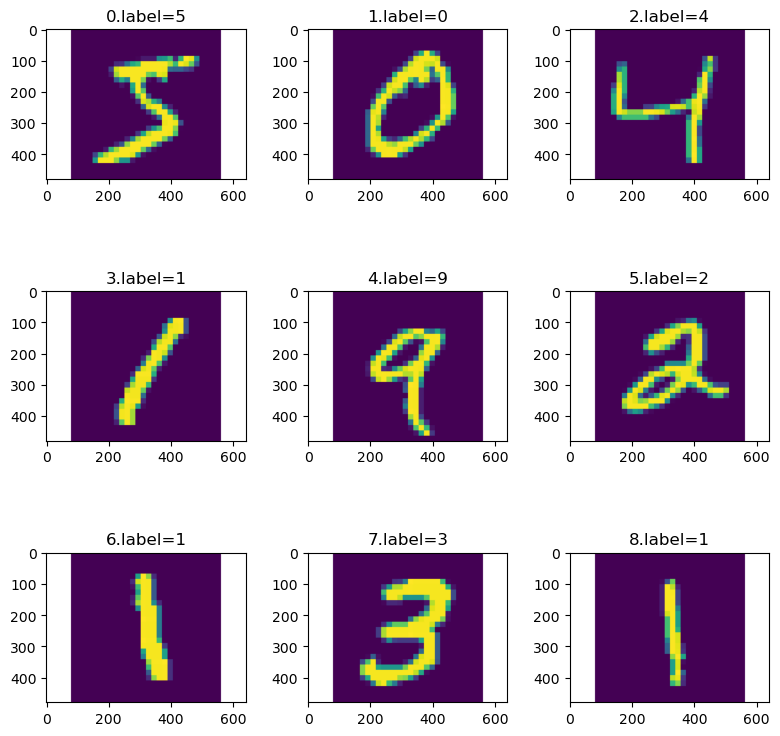

In [23]:
my_loader2 = DataLoader(my_data, batch_size=9)
for x_batch, y_batch in my_loader2:
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
    plt.tight_layout()
    for i in range(len(y_batch)):
        row_num = int(i/3)
        col_num = i%3
        ax[row_num, col_num].imshow(x_batch[i])
        ax[row_num, col_num].set_title(f'{i}.label={y_batch[i]}')
    break